Copyright (c) 2023 wcyat

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE PREDICTED DATA MUST NOT BE USED TO SUBMIT TO THE COMPETITION AI Challenge – 
Weather Forecasting Competition (2023) ORGANIZED BY HKEDCITY, MICROSOFT AND OTHERS.
<https://www.edcity.hk/coding/en/WeatherForecasting>

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [252]:
!pip install seaborn
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import joblib
import seaborn as sns
from datetime import timedelta
import tensorflow as tf


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


Load the data

In [253]:
!mkdir data
!if ! [ -f "data/processed_data.csv" ]; then wget https://github.com/sdip15fa/weather-predict/raw/master/data/processed_data.csv -O data/processed_data.csv; fi;

input_file = 'data/processed_data.csv'
df = pd.read_csv('data/processed_data.csv',
                 parse_dates=['DateTime'], index_col='DateTime')
df = df.resample('60T').mean()
# df["DateTime"] = pd.to_datetime(df.index)
df = df.reset_index()

mkdir: cannot create directory ‘data’: File exists


Convert the 'Date' and 'Time' columns to integers

In [254]:
df["Temperature"] = df["Temperature"].astype(float)
df["Wind Speed"] = df["Wind Speed"].astype(float)
df["Rainfall"] = df["Rainfall"].astype(float)
df["Wind Direction"] = df["Wind Direction"].astype(float)
df["Humidity"] = df["Humidity"].astype(float)

Filter and replace outliers

In [255]:
df['Temperature'] = df['Temperature'].replace(3276.7, np.nan)
df['Wind Speed'] = df['Wind Speed'].replace(32767, np.nan)
df['Rainfall'] = df['Rainfall'].replace(32767, np.nan)
df['Wind Direction'] = df['Wind Direction'].replace(32767, np.nan)
df['Humidity'] = df['Humidity'].replace(32767, np.nan)
df['Temperature'] = df['Temperature'].mask((df['Temperature'] > 40) | (df['Temperature'] < -10), np.nan)
df['Wind Speed'] = df['Wind Speed'].mask((df['Wind Speed'] > 200) | df["Wind Speed"] < 0, np.nan)
df['Rainfall'] = df['Rainfall'].mask((df['Rainfall'] > 500)| df["Rainfall"] < 0, np.nan)
df['Wind Direction'] = df['Wind Direction'].mask((df['Wind Direction'] < 0) | (df['Wind Direction'] > 360), np.nan)
df['Humidity'] = df['Humidity'].mask((df['Humidity'] < 0) | (df['Humidity'] > 100), np.nan)

In [256]:
df[df.isna().any(axis=1)]

,DateTime,Year,Month,Date,Time,Minute,Temperature,Wind Speed,Wind Direction,Rainfall,Humidity
36,2008-01-02 12:00:00,2008.0,1.0,2.0,12.0,1.0,NaN,NaN,NaN,NaN,NaN
38,2008-01-02 14:00:00,2008.0,1.0,2.0,14.0,1.0,11.2,19.0,NaN,0.0,27.0
39,2008-01-02 15:00:00,2008.0,1.0,2.0,15.0,1.0,10.7,13.0,NaN,0.0,31.0
59,2008-01-03 11:00:00,2008.0,1.0,3.0,11.0,1.0,11.9,15.0,NaN,0.0,36.0
111,2008-01-05 15:00:00,2008.0,1.0,5.0,15.0,1.0,16.0,10.0,NaN,0.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...
134727,2023-05-15 15:00:00,2023.0,5.0,15.0,15.0,1.0,NaN,19.0,26.0,0.0,NaN
134728,2023-05-15 16:00:00,2023.0,5.0,15.0,16.0,1.0,NaN,1.0,265.0,0.0,NaN
135060,2023-05-29 12:00:00,2023.0,5.0,29.0,12.0,1.0,NaN,41.0,273.0,0.0,NaN
135109,2023-05-31 13:00:00,2023.0,5.0,31.0,13.0,1.0,27.4,13.0,NaN,0.0,88.0


In [257]:
df = df.fillna(method="ffill").fillna(method="bfill")

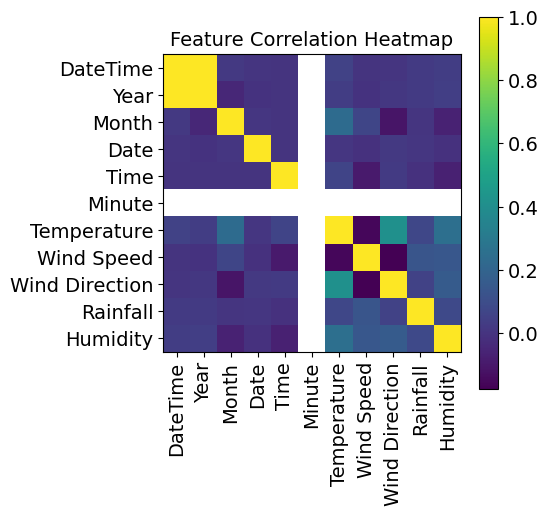

In [258]:

def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

In [259]:
time_steps = 144  # Number of time steps for the LSTM model
forward_steps = 16 # how many steps to predict
scaler = StandardScaler() # MinMaxScaler(feature_range=(0, 1))  # Scale the data to [0, 1]

In [260]:
features_keys = ['Temperature', 'Wind Speed',
               'Rainfall', 'Humidity']

In [261]:
features = df[features_keys].copy()
scaler.fit(features)

StandardScaler()

In [262]:
"""
pretrained_model: tf.keras.Model = None
try:
    pretrained_model = tf.keras.models.load_model("lstm.keras")
except:
    pass

if pretrained_model:
    for col in features_keys:
        indices = df[df[col].isna() == True].index.values
        if len(indices) > 0:
            input_data = []
            for i in indices:
                input_data_i = df[features_keys].iloc[i-time_steps-1:i-1].values
                if len(input_data_i):
                    input_data_i = scaler.transform(pd.DataFrame(input_data_i, columns=features_keys))
                    input_data.append(input_data_i)
                else:
                    indices = np.delete(indices, i)
            if len(input_data):
                input_data = np.array(input_data).reshape(len(input_data), time_steps, len(features_keys))
                predicted = pd.DataFrame(pretrained_model.predict(input_data), columns=features_keys, index=indices)[col].values
                df.loc[indices, col] = predicted
"""

'\npretrained_model: tf.keras.Model = None\ntry:\n    pretrained_model = tf.keras.models.load_model("lstm.keras")\nexcept:\n    pass\n\nif pretrained_model:\n    for col in features_keys:\n        indices = df[df[col].isna() == True].index.values\n        if len(indices) > 0:\n            input_data = []\n            for i in indices:\n                input_data_i = df[features_keys].iloc[i-time_steps-1:i-1].values\n                if len(input_data_i):\n                    input_data_i = scaler.transform(pd.DataFrame(input_data_i, columns=features_keys))\n                    input_data.append(input_data_i)\n                else:\n                    indices = np.delete(indices, i)\n            if len(input_data):\n                input_data = np.array(input_data).reshape(len(input_data), time_steps, len(features_keys))\n                predicted = pd.DataFrame(pretrained_model.predict(input_data), columns=features_keys, index=indices)[col].values\n                df.loc[indices, col] 

Prepare the data for LSTM

Remove rows with missing values

In [263]:
df = df.dropna().reset_index()

In [264]:
df

,index,DateTime,Year,Month,Date,Time,Minute,Temperature,Wind Speed,Wind Direction,Rainfall,Humidity
0,0,2008-01-01 00:00:00,2008.0,1.0,1.0,0.0,1.0,3.6,107.0,49.0,0.0,37.0
1,1,2008-01-01 01:00:00,2008.0,1.0,1.0,1.0,1.0,3.0,103.0,42.0,0.0,35.0
2,2,2008-01-01 02:00:00,2008.0,1.0,1.0,2.0,1.0,2.3,101.0,39.0,0.0,37.0
3,3,2008-01-01 03:00:00,2008.0,1.0,1.0,3.0,1.0,2.4,92.0,47.0,0.0,33.0
4,4,2008-01-01 04:00:00,2008.0,1.0,1.0,4.0,1.0,2.0,102.0,47.0,0.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...
135964,135964,2023-07-06 04:00:00,2023.0,7.0,6.0,4.0,1.0,21.5,129.0,213.0,0.0,100.0
135965,135965,2023-07-06 05:00:00,2023.0,7.0,6.0,5.0,1.0,21.2,110.0,216.0,0.0,100.0
135966,135966,2023-07-06 06:00:00,2023.0,7.0,6.0,6.0,1.0,21.1,123.0,215.0,0.0,100.0
135967,135967,2023-07-06 07:00:00,2023.0,7.0,6.0,7.0,1.0,21.7,126.0,219.0,5.0,100.0


Check if any hours are missing

In [265]:
"""
# Get the minimum and maximum DateTime values in the DataFrame
min_time = df['DateTime'].min()
max_time = df['DateTime'].max()

# Create a complete sequence of hours using pandas date_range
complete_hours = pd.date_range(start=min_time, end=max_time, freq='H')

# Extract the unique hours from the DataFrame
existing_hours = pd.to_datetime(df['DateTime']).unique()

# Find the missing hours by comparing the complete sequence with the existing hours
missing_hours = [hour for hour in complete_hours if hour not in existing_hours]

# Print the missing hours
print(missing_hours)
"""

"\n# Get the minimum and maximum DateTime values in the DataFrame\nmin_time = df['DateTime'].min()\nmax_time = df['DateTime'].max()\n\n# Create a complete sequence of hours using pandas date_range\ncomplete_hours = pd.date_range(start=min_time, end=max_time, freq='H')\n\n# Extract the unique hours from the DataFrame\nexisting_hours = pd.to_datetime(df['DateTime']).unique()\n\n# Find the missing hours by comparing the complete sequence with the existing hours\nmissing_hours = [hour for hour in complete_hours if hour not in existing_hours]\n\n# Print the missing hours\nprint(missing_hours)\n"

Scale the temperature, wind speed, rainfall, and wind direction values

In [266]:
features = df[features_keys].copy()
scaled_features = scaler.transform(features)

In [267]:
scaled_features

array([[-2.6387726 ,  0.83318941, -0.14952625, -3.28115754],
       [-2.75474832,  0.74011581, -0.14952625, -3.40554006],
       [-2.89005332,  0.69357901, -0.14952625, -3.28115754],
       ...,
       [ 0.74385247,  1.20548381, -0.14952625,  0.63689175],
       [ 0.85982818,  1.27528901,  0.09733722,  0.63689175],
       [ 0.95647461,  0.53070021, -0.14952625,  0.63689175]])

Create sequences of input data and corresponding target values

In [268]:
data = []
target = []
for i in range(1, len(scaled_features) - time_steps - forward_steps):
    data.append(scaled_features[i:i+time_steps])
    target.append(scaled_features[i+time_steps:i+time_steps+forward_steps])

In [269]:
data = np.array(data)
target = np.array(target)

In [270]:
target.shape

(135808, 16, 4)

Split the dataset into training and validation sets

In [271]:
split = 0.05
random_state = 42

random.seed(random_state)
np.random.seed(random_state)

val_index = (pd.Series([random.random() for _ in range(len(target))]) < split).values

train_data, train_target = data[~val_index], target[~val_index]
val_data, val_target = data[val_index], target[val_index]

Build the LSTM model architecture

In [144]:
output_shape = (forward_steps, len(features_keys))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

model = None

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(512, input_shape=(time_steps, len(features_keys))),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(output_shape[0] * output_shape[1]),
        tf.keras.layers.Reshape(output_shape)
    ])
    model.compile(loss='mae', optimizer=optimizer)

ValueError: Please provide a TPU Name to connect to.

Define early stopping and learning rate scheduler

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

Train the LSTM model

In [ ]:
batch_size = 4096
epochs = 250
history = model.fit(train_data, train_target, batch_size=batch_size, epochs=epochs, validation_data=(val_data, val_target),
                    callbacks=[early_stopping, lr_scheduler])

In [ ]:
# Access the loss values from the training history
train_losses = history.history['loss']
val_losses = history.history['val_loss']

# Plot the loss values
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Make predictions using the trained LSTM model

In [235]:
predictions = model.predict(val_data)

210/210 [==============================] - 17s 80ms/step


Rescale the predictions back to the original range

In [236]:
scaled_predictions = pd.DataFrame(predictions.flatten().reshape(-1, len(features_keys)), columns=features_keys)
predictions = pd.DataFrame(scaler.inverse_transform(scaled_predictions), columns=features_keys)
predicted_temperature = predictions["Temperature"]


In [238]:
val_target_flattened = val_target.flatten().reshape(-1, len(features_keys))
val_target_rescaled = pd.DataFrame(scaler.inverse_transform(val_target_flattened), columns=features_keys)
train_target_flattened = train_target.flatten().reshape(-1, len(features_keys))
train_target_rescaled = pd.DataFrame(scaler.inverse_transform(train_target_flattened), columns=features_keys)

Calculate MSE and MAE

In [239]:
mse = mean_squared_error(val_target_rescaled["Temperature"], predictions["Temperature"])
mae = mean_absolute_error(val_target_rescaled["Temperature"], predictions["Temperature"])

In [240]:
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 0.1826492247864434
Mean Absolute Error (MAE): 0.26996809829415375


Visualize the actual vs. predicted temperatures for the validation set

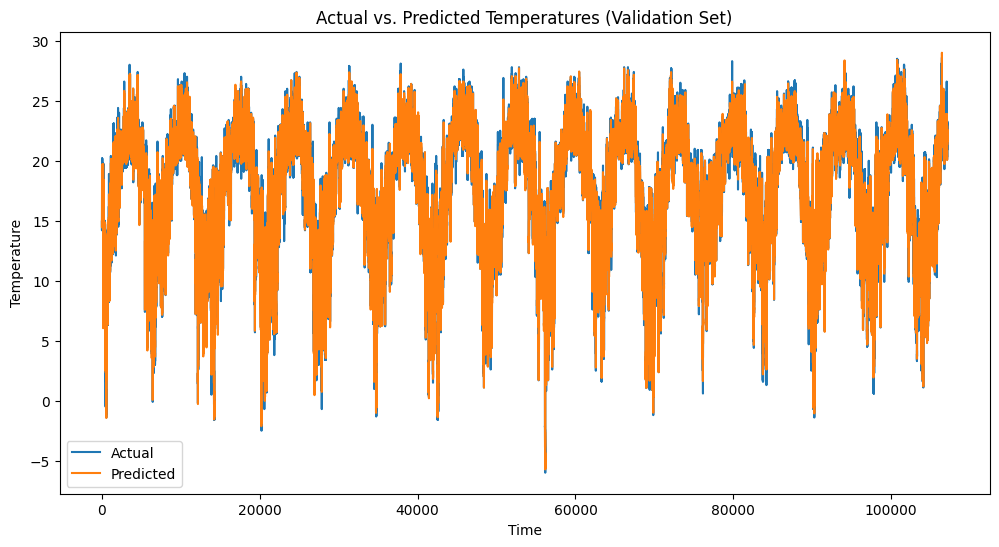

In [185]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(val_target)), val_target_rescaled["Temperature"], label='Actual')
plt.plot(range(len(val_target)), predicted_temperature, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Actual vs. Predicted Temperatures (Validation Set)')
plt.legend()
plt.show()

Save the trained model

In [ ]:
model.save("lstm.keras")

In [ ]:
joblib.dump(scaler, "scaler.save")

In [272]:
model = tf.keras.models.load_model("lstm.keras")
scaler = joblib.load("scaler.save")

2023-07-06 20:18:25.618967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-06 20:18:25.621083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-06 20:18:25.622012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [273]:
# df = df[((df["Month"] == 6) & (df["Date"] > 24)) | ((df["Month"] == 7) & (df["Date"] < 10))]

features = df[features_keys].copy()
scaled_features = scaler.transform(features)
data = []
target = []
for i in range(1, len(scaled_features) - time_steps - forward_steps):
    data.append(scaled_features[i:i+time_steps])
    target.append(scaled_features[i+time_steps:i+time_steps+forward_steps])
data = np.array(data)
target = np.array(target)

Test random samples

In [274]:
total_samples = 1000

def test_samples(total_samples: int = 20):
    mse = []
    mae = []
    sample_results = []
    sample_datum = []
    sample_targets = []
     
    sample_indices = random.sample(range(len(val_data)), total_samples)  # Randomly select sample indices
    
    sample_data = val_data[sample_indices]  # Extract the randomly selected samples
    sample_targets = val_target[sample_indices]  # Extract the corresponding targets

    scaled_predictions = model.predict(sample_data.reshape(total_samples, time_steps, len(features_keys)), verbose=0)

    for i in range(total_samples):
        sample_predicted = scaler.inverse_transform(scaled_predictions[i])

        sample_result = pd.DataFrame(sample_predicted, columns=features_keys)
        sample_results.append(sample_result)

        mse.append(mean_squared_error(
            sample_result["Temperature"], scaler.inverse_transform(sample_targets[i])[:, 0]))
        mae.append(mean_absolute_error(
            sample_result["Temperature"], scaler.inverse_transform(sample_targets[i])[:, 0]))

        sample_datum.append(sample_data[i])
    
    print("Mean mse:", np.array(mse).mean())
    print("Mean mae:", np.array(mae).mean())
    
    return sample_datum, sample_targets, sample_results, mse, mae

sample_datum, sample_targets, sample_results, mse, mae = test_samples(total_samples)

2023-07-06 20:18:28.071882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-06 20:18:28.073291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-06 20:18:28.074117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Mean mse: 0.1901177585952747
Mean mae: 0.27080895616708667


Mean squared error of sample: 0.15920945698460598
Mean absolute error of sample: 0.3304716540287038


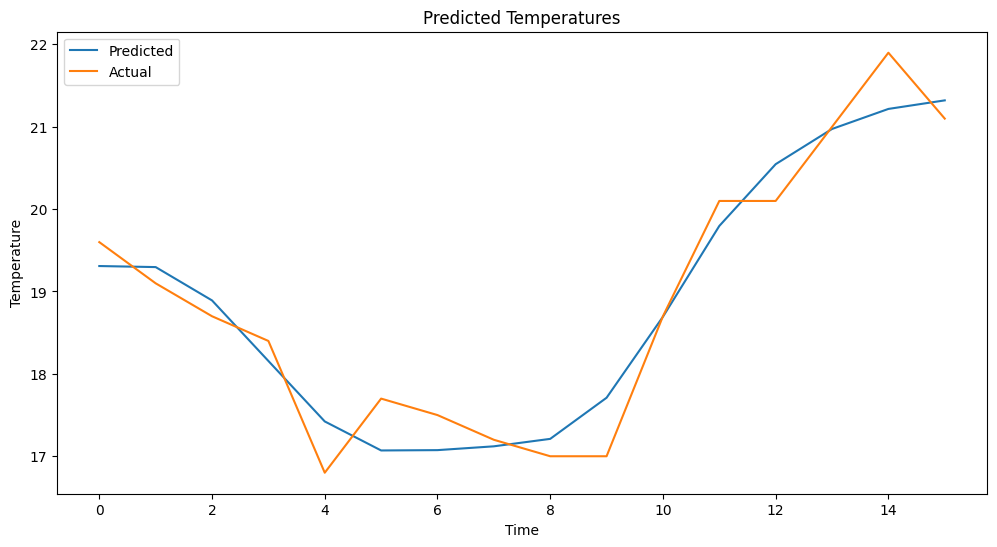

In [275]:
rand_int = random.randint(0, total_samples - 1)

print("Mean squared error of sample:", mean_squared_error(
    sample_results[rand_int]["Temperature"], scaler.inverse_transform(sample_targets[rand_int])[:, 0]))
print("Mean absolute error of sample:", mean_absolute_error(
    sample_results[rand_int]["Temperature"], scaler.inverse_transform(sample_targets[rand_int])[:, 0]))

plt.figure(figsize=(12, 6))
plt.plot(range(len(sample_results[rand_int])), sample_results[rand_int]["Temperature"], label='Predicted')
plt.plot(range(len(sample_results[rand_int])), scaler.inverse_transform(sample_targets[rand_int])[:, 0], label="Actual")
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Predicted Temperatures')
plt.legend()
plt.show()

In [276]:
test_data = scaled_features.copy()[-time_steps:]

scaled_predictions = model.predict(test_data.reshape(1, time_steps, len(features_keys)))[0]
predicted = scaler.inverse_transform(scaled_predictions)
# print(f'{df["DateTime"].max() + timedelta(hours=i)}:', list(map(lambda x: round(x, 6), predicted)))
# print(prediction's [0], test_data, np.append(test_data, prediction[0]))

1/1 [==============================] - 0s 34ms/step


In [277]:
results = pd.DataFrame(predicted, columns=features_keys)
results.insert(0, "DateTime", [df["DateTime"].max() + timedelta(hours=i) for i in range(1, forward_steps + 1)])
results.to_csv("predict.csv")

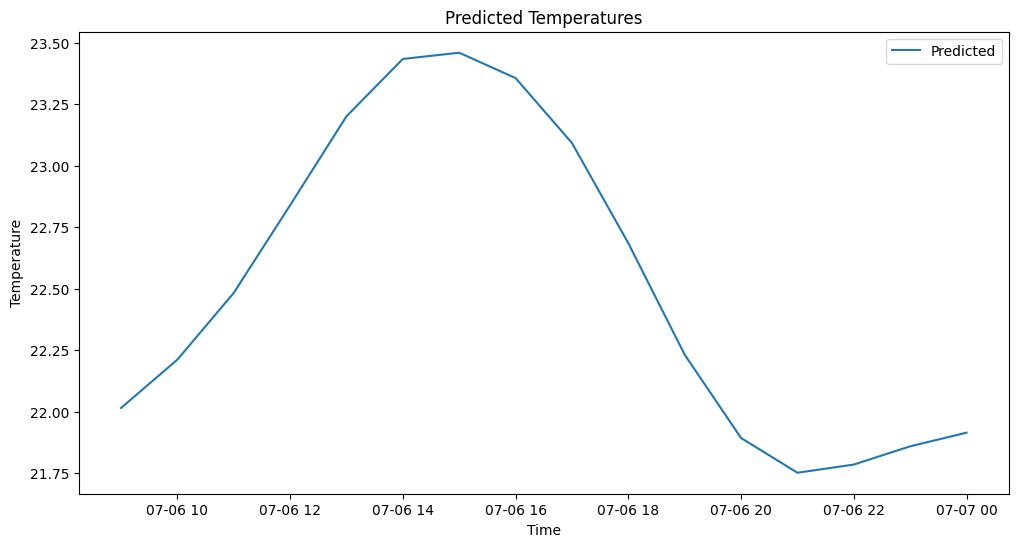

In [278]:
plt.figure(figsize=(12, 6))
plt.plot(results["DateTime"], np.array(predicted)[:, 0], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Predicted Temperatures')
plt.legend()
plt.show()